In [1]:
# imports
import xml.etree.ElementTree as ET
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import os
import xmltodict
import contextily as cx
import matplotlib.pyplot as plt

In [2]:
output_folder = 'new output/'
output = output_folder + 'edge_data_hour_output.xml'



## Looking at the travel time for trips within downtown seattle 

### reading files
Make sure the addresses are correct

In [3]:
os.chdir("..")
os.path.abspath(os.curdir)

'C:\\Users\\Soheil99\\GoogleDrive\\My Drive\\reasearch codes\\DowntownSeattleSUMO'

In [4]:
# reading information about TAZs
## Load shapefiles
taz_data = gpd.read_file('Demand generation/modified shp file/taz2010.shp')

## load sumo tazs
tree = ET.parse('Simulation/clean corrected inputs/correct_Alaskan_modified_new_Taz_with_pseudo.add.xml')
root = tree.getroot()
sumo_taz = []
for taz in root.findall('taz'):
    tazid = taz.get('id')
    if tazid != 'taz_13' and int(tazid)<5000:
        sumo_taz.append(int(tazid))
        
        
# reading calibration/real data
demand_start, demand_end = 5, 10  #am
real_data = pd.read_csv('Demand generation/psrc_vehicle_trips_converted_taz_calibrated.csv')  # read the output of pTAZ assignment

In [5]:
# reading output file
columns = ['id', 'depart', 'duration']
with open('Simulation/Apr4 final/tripinfo_output.xml', 'r') as xml_file:
    data_dict = xmltodict.parse(xml_file.read())
data_list = data_dict['tripinfos']['tripinfo']
out_data = pd.json_normalize(data_list)[['@'+col for col in columns]]
out_data.columns = columns
out_data['duration'] = out_data['duration'].astype(float)
out_data['depart'] = out_data['depart'].astype(float)


# # reading the demand file.
# ## it should be the demand before the adjustment process (in which we can find origin and destination TAZs for all trips)
columns = ['id','fromTaz', 'toTaz', 'depart']
with open('Simulation/alaskanway_od2trips_psrc_vehicle_trips_converted_taz_calibrated_V3.rou.xml', 'r') as xml_file:
    data_dict = xmltodict.parse(xml_file.read())
data_list = data_dict['routes']['trip']
demand_data = pd.json_normalize(data_list)[['@'+col for col in columns]]
demand_data.columns = columns
demand_data['fromTaz'] = demand_data['fromTaz'].astype(int)
demand_data['toTaz'] = demand_data['toTaz'].astype(int)
demand_data['depart'] = demand_data['depart'].astype(float)

In [6]:
simulation_data = demand_data.iloc[:, :3].merge(out_data, on='id')
simulation_data['depart'] = simulation_data['depart']//60
simulation_data['duration'] = round(simulation_data['duration']/60, 1)
simulation_data.sample(5)

,id,fromTaz,toTaz,depart,duration
43552,40130,441,513,411.0,5.5
64186,67891,5002,458,436.0,14.2
32780,35758,5008,5011,394.0,4.2
134736,136103,5002,541,515.0,10.9
80360,81707,5004,568,458.0,17.3


### calculating the difference in travel time

In [7]:
# find all valid pairs from cal_data and for each TAZ pair, find average travel time
## Just looking at od trips inside downtown since their travel time is more reliable

real_data = real_data[real_data.otaz.isin(sumo_taz) & real_data.dtaz.isin(sumo_taz)]  # 100k out of 670 trips
real_data = real_data[(real_data.deptm>=demand_start*60) & (real_data.deptm<=demand_end*60)]  # 167k out of 670k trips
real_data.loc[real_data.travtime==0, 'travtime']=1
real_data_grouped = round(real_data.groupby(by=['otaz', 'dtaz']).travtime.mean(),1)
print(sorted(real_data_grouped, reverse=True)[:10])
real_data_grouped = real_data_grouped[real_data_grouped != max(real_data_grouped)]  # the max looked like an outlier

real_pairs_and_times = real_data_grouped.to_dict()
real_pairs_and_times

[62.0, 24.0, 24.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]


{(426, 426): 5.4,
 (426, 427): 7.3,
 (426, 428): 6.6,
 (426, 429): 5.0,
 (426, 430): 9.9,
 (426, 431): 9.4,
 (426, 432): 10.8,
 (426, 433): 10.8,
 (426, 434): 11.5,
 (426, 435): 11.0,
 (426, 437): 12.3,
 (426, 438): 14.0,
 (426, 439): 12.0,
 (426, 442): 15.0,
 (426, 443): 15.0,
 (426, 447): 14.0,
 (426, 450): 14.0,
 (426, 452): 14.0,
 (426, 456): 13.0,
 (426, 459): 14.0,
 (426, 460): 13.0,
 (426, 463): 12.0,
 (426, 467): 13.0,
 (426, 468): 12.0,
 (426, 469): 12.0,
 (426, 470): 12.0,
 (426, 472): 12.0,
 (426, 473): 11.3,
 (426, 474): 11.0,
 (426, 475): 11.5,
 (426, 476): 11.3,
 (426, 477): 10.3,
 (426, 480): 12.3,
 (426, 481): 12.0,
 (426, 483): 13.0,
 (426, 484): 11.0,
 (426, 485): 11.0,
 (426, 486): 10.0,
 (426, 487): 12.0,
 (426, 488): 11.0,
 (426, 489): 10.4,
 (426, 490): 10.0,
 (426, 491): 10.5,
 (426, 492): 10.3,
 (426, 493): 10.4,
 (426, 496): 9.5,
 (426, 498): 11.0,
 (426, 499): 10.3,
 (426, 500): 12.0,
 (426, 501): 10.0,
 (426, 502): 10.7,
 (426, 503): 9.5,
 (426, 504): 9.4,
 (

In [8]:
# for TAZ pairs in output data, find average travel time
sim_data_grouped = round(simulation_data.groupby(by=['fromTaz', 'toTaz']).duration.mean(),1)
print(sorted(sim_data_grouped, reverse=True)[:10])
sim_data_grouped = sim_data_grouped[sim_data_grouped != max(sim_data_grouped)]  # the max looked like an outlier
sim_pairs_and_times = sim_data_grouped.to_dict()
sim_pairs_and_times

[77.6, 67.6, 64.2, 61.3, 61.3, 55.5, 54.9, 50.0, 49.3, 49.0]


{(426, 426): 1.4,
 (426, 427): 1.8,
 (426, 428): 2.2,
 (426, 429): 9.4,
 (426, 430): 12.3,
 (426, 431): 9.3,
 (426, 432): 11.4,
 (426, 433): 17.2,
 (426, 434): 7.2,
 (426, 435): 9.8,
 (426, 437): 10.8,
 (426, 439): 10.2,
 (426, 442): 13.4,
 (426, 450): 20.8,
 (426, 452): 26.2,
 (426, 460): 25.8,
 (426, 467): 13.7,
 (426, 468): 22.1,
 (426, 469): 31.2,
 (426, 470): 9.1,
 (426, 472): 16.2,
 (426, 473): 7.1,
 (426, 474): 7.5,
 (426, 475): 11.4,
 (426, 476): 11.4,
 (426, 477): 8.0,
 (426, 480): 16.5,
 (426, 481): 9.6,
 (426, 483): 23.1,
 (426, 484): 14.2,
 (426, 485): 14.2,
 (426, 486): 20.7,
 (426, 487): 16.4,
 (426, 488): 12.8,
 (426, 489): 11.2,
 (426, 490): 6.8,
 (426, 491): 5.8,
 (426, 492): 14.0,
 (426, 493): 10.1,
 (426, 496): 16.0,
 (426, 498): 17.7,
 (426, 499): 21.0,
 (426, 500): 29.6,
 (426, 501): 14.7,
 (426, 502): 18.7,
 (426, 503): 11.1,
 (426, 504): 16.7,
 (426, 505): 6.8,
 (426, 506): 14.3,
 (426, 508): 11.6,
 (426, 509): 18.2,
 (426, 510): 26.3,
 (426, 512): 21.4,
 (426, 5

In [9]:
# for TAZ pairs, find percentage error
errors = {}
for o, d in real_pairs_and_times.keys():
    if sim_pairs_and_times.get((o, d), False):
        real = real_pairs_and_times[(o, d)]
        simulation = sim_pairs_and_times[(o, d)]
        error = round((simulation-real)/real*100,1)
        errors[(o,d)] = error

### Showing on map
show error percentages on map - thickness ~ abs percentage, color ~ positive or negative error

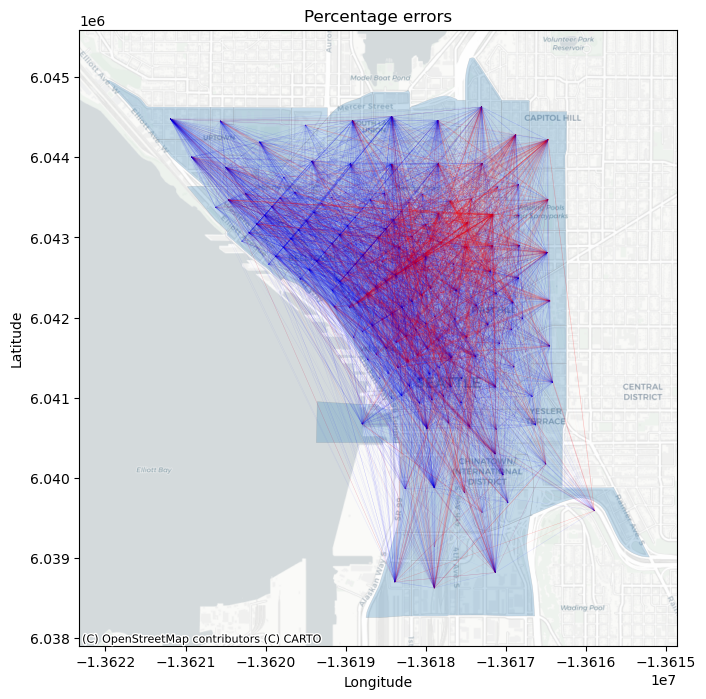

In [10]:
downtown_shp = taz_data.loc[taz_data['TAZ'].isin(sumo_taz)].to_crs(epsg=3857)
ax = downtown_shp.plot(figsize=(8, 8), alpha=0.25, linewidth=0.4, edgecolor="grey", legend=True)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=14)

for o,d in list(errors.keys()):
    start_point = downtown_shp[downtown_shp['TAZ'] == o].geometry.iloc[0].centroid
    end_point = downtown_shp[downtown_shp['TAZ'] == d].geometry.iloc[0].centroid
    error = errors[(o,d)]
    clr, a = 'blue', 0.1
    if error>0:  # positive error is red, negative is blue
        clr, a = 'red', 0.2
    plt.plot([start_point.x, end_point.x], [start_point.y, end_point.y], linewidth=abs(error)/200, color=clr, alpha=a)


plt.title('Percentage errors')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()      

In [11]:
pos = 0
neg = 0
for val in errors.values():
    if val>0:
        pos+=1
    elif val<0:
        neg+=1
print(f'positive errors: {pos}')
print(f'negative errors: {neg}')

positive errors: 1526
negative errors: 7528


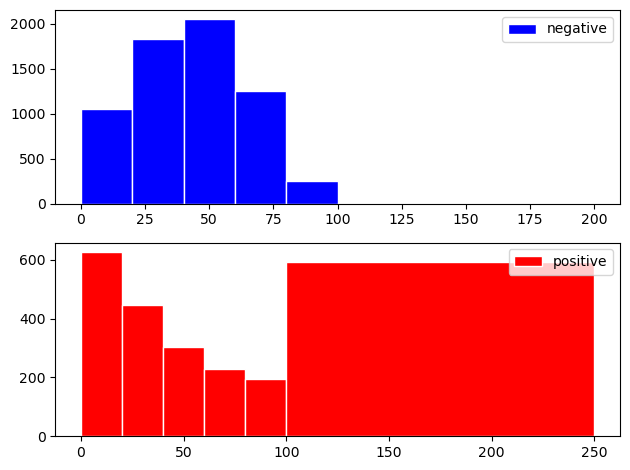

In [26]:
pos = []
neg = []
for val in errors.values():
    if val>0:
        pos.append(abs(val))
    elif val<0:
        neg.append(abs(val))            
fig, axs = plt.subplots(2, 1, tight_layout=True)
axs[0].hist(neg, color='blue', label='negative',  bins=[0,20,40,60,80,100,200], edgecolor='white')
axs[0].legend()
axs[1].hist(pos, color='red', label='positive', bins=[0,20,40,60,80,100,250], edgecolor='white')
axs[1].legend()
# # Add labels and title
# plt.xlabel('Values')
# plt.ylabel('Frequency')
# plt.title('Histogram with Red Color')
plt.show()

In [13]:
num = 0
for o,d in list(errors.keys()):
    error = errors[(o,d)]
    if error>250:
        num += 1
        print(o, d, error)
print(num)

426 469 399.2
426 472 502.5
426 530 402.2
427 494 268.0
427 570 313.3
428 509 326.9
428 520 378.6
429 484 406.7
429 530 273.8
431 484 368.9
434 607 323.3
436 466 268.9
437 529 272.9
438 506 321.7
441 545 374.1
442 516 256.9
443 503 269.1
443 545 297.6
446 503 300.0
447 573 270.8
448 566 369.2
452 531 316.4
452 568 373.6
454 529 293.1
455 493 256.0
459 493 255.8
460 438 510.0
464 516 508.8
464 566 320.9
465 507 296.7
467 486 371.0
468 491 541.0
468 569 454.0
470 502 301.1
472 569 423.3
474 432 317.8
474 575 270.0
474 606 295.0
476 496 260.0
476 504 413.8
479 493 300.0
481 486 270.0
481 488 274.3
481 494 295.7
481 504 253.3
482 514 478.3
482 571 291.1
483 427 303.3
483 501 498.3
483 504 281.7
483 530 434.4
483 569 403.7
484 489 301.7
484 529 289.1
485 495 566.2
485 502 328.0
486 493 766.7
486 583 464.0
487 504 518.3
487 512 297.5
487 531 298.2
487 572 305.0
488 491 354.5
488 515 335.0
489 524 300.0
489 531 530.0
490 505 320.0
490 519 254.5
491 503 304.4
492 503 380.0
493 491 490.0
493 49

In [14]:
max(errors.values())

967.5

In [15]:
simulation_data[(simulation_data.fromTaz==532)&(simulation_data.toTaz==532 )]

,id,fromTaz,toTaz,depart,duration
185451,192936,532,532,573.0,8.6


In [16]:
real_data[(real_data.otaz==532)&(real_data.dtaz==532 )]

,otaz,dtaz,deptm,travtime,original_o,original_d,original_deptm
306521,532,532,581,1,532,532,581


In [17]:
thresh=20
u20=0
c=0
s = 0
for o,d in list(errors.keys()):
    error = abs(errors[(o,d)])
    s += error
    c += 1
    if error<thresh:
        u20+=1
        
print('for trips within downtown seattle:')
print(f'total OD pairs: {c}')
print(f'percents of errors under {thresh}%: {round(u20/len(errors)*100,2)}')
print(f'mean absolute error: {s/c}')

for trips within downtown seattle:
total OD pairs: 9102
percents of errors under 20%: 18.94
mean absolute error: 56.47144583608013


In [18]:
print(sum(neg)/len(neg))

42.58786046511628


In [19]:
print(sum(pos)/len(pos))

91.65507468402915


In [20]:
print(sum(list(errors.values()))/len(errors))

-3.887090749285877


### Reduce 5mph of speeds?